# Imagenet Example

This notebook demonstrates the iNNvestigate at hand of pre-trained ImageNet models, which requires more capable hardware than the [mnist-based example](./mnist_example.ipynb), but will follow the same pattern overall: First we will deal with all necessary imports, then load he model and some test data, and finally specify, create and run our analyzers before visualizing the analysis results.

# Imports

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
%matplotlib inline  

import numpy as np
import time
import imp
import os

import keras
import keras.backend
import keras.models
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Input
from keras.optimizers import RMSprop

import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.tests.networks.base
import innvestigate.utils.visualizations as ivis

eutils = imp.load_source("utils", "../utils.py")
imgnetutils = imp.load_source("utils_imagenet", "../utils_imagenet.py")

Using TensorFlow backend.


# Model

In this demo, we load a VGG16-model trained on ImageNet, which uses ReLU activation layers. As in our MNIST demo, we use a model using the network's softmax output for inferrence and the immediately preceding logit output for analysis purposes.

In [4]:
# Parameter
netname = "vgg16"
pattern_type = "relu"

In [5]:
# Build Model
tmp = getattr(innvestigate.applications.imagenet, netname)
net = tmp(load_weights=True, load_patterns=pattern_type)

model = keras.models.Model(inputs=net["in"], outputs=net["out"])
model.compile(optimizer="adam", loss="categorical_crossentropy")
modelp = keras.models.Model(inputs=net["in"], outputs=net["sm_out"])
modelp.compile(optimizer="adam", loss="categorical_crossentropy")

# Handle input depending on model and backend
channels_first = keras.backend.image_data_format == "channels_first"
color_conversion = "BGRtoRGB" if net["color_coding"] == "BGR" else None

# Data

Next, load some pre-selected example images from the ImageNet test set and prepare them to fit the input size of the loaded model. To analyze your own example (from the ImageNet test set -- it must for now match the ImageNet image name to label mapping) images, just add them to `innvestigate/examples/images`.

In [6]:
# Get some example test set images.
images, label_to_class_name = eutils.get_imagenet_data(
    net["image_shape"][0])

# Analysis

Next, we will set up a list of analysis methods by preparing tuples containing the methods' string identifiers used by `innvestigate.analyzer.create_analyzer(...)`, some optional parameters, a post processing choice for visualizing the computed analysis and a title for the figure to render. Analyzers can be deactivated by simply commenting the corresponding lines, or added by creating a new tuple as below.

For a full list of methods refer to the dictionary `investigate.analyzer.analyzers`
Note: Should you run into resource trouble, e.g. you are running that notebook on a notebook without or with only limited GPU memory, consider deactivating one or more analyzers by commenting the corresponding lines in the next cell, or execute this notebook on a CPU (in that case, go and grab a coffee).

In [6]:
# Determine analysis methods and properties
patterns = net["patterns"]
# Methods we use and some properties.
methods = [
    # NAME                    OPT.PARAMS               POSTPROC FXN             TITLE
    # Show input.
    ("input",                 {},                       in_utils.image,         "Input"),

    # Function
    ("gradient",              {},                       in_utils.graymap,       "Gradient"),
    ("smoothgrad",            {"noise_scale": 50},      in_utils.graymap,       "SmoothGrad"),
    ("integrated_gradients",  {},                       in_utils.graymap,       "Integrated Gradients"),

    # Signal
    ("deconvnet",             {},                       in_utils.bk_proj,       "Deconvnet"),
    ("guided_backprop",       {},                       in_utils.bk_proj,       "Guided Backprop",),
    ("pattern.net",           {"patterns": patterns},   in_utils.bk_proj,       "PatternNet"),

    # Interaction
    ("pattern.attribution",   {"patterns": patterns},   in_utils.heatmap,       "PatternAttribution"),
    ("lrp.z_baseline",        {},                       in_utils.heatmap,       "Gradient*Input"),
    ("lrp.z",                 {},                       in_utils.heatmap,       "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           in_utils.heatmap,       "LRP-Epsilon"),
    ("lrp.composite_a_flat",  {"epsilon": 1},           in_utils.heatmap,       "LRP-CompositeAFlat"),
    ("lrp.composite_b_flat",  {"epsilon": 1},           in_utils.heatmap,       "LRP-CompositeBFlat"),
    ]

In [7]:
# Create analyzers.
analyzers = []
print('Create analyzer for ', flush=True)
for method in methods:
    print('{} '.format(''.join(method[3])), flush=True)
    analyzers.append(innvestigate.create_analyzer(method[0], 
                                                  model, 
                                                  **method[1]))

# Apply analyzers to trained VGG model.
color_conversion = "BGRtoRGB" if net["color_coding"] == "BGR" else None
analysis = np.zeros([len(images), len(analyzers), 224, 224, 3])
text = []
for i, (image, y) in enumerate(images):
    image = image[None, :, :, :]
    # Predict label.
    x = imgnetutils.preprocess(image, net)
    presm = model.predict_on_batch(x)[0]
    prob = modelp.predict_on_batch(x)[0]
    y_hat = prob.argmax()

   # Save label, pre-softmax activation, probabilistic output and predicted label for plots
    text.append(("%s" %label_to_class_name[y], "%.2f" %presm.max(), 
                 "%.2f" % prob.max(), "%s" %label_to_class_name[y_hat]))
    
    for aidx, analyzer in enumerate(analyzers):
        # Measure execution time
        t_start = time.time()
        print('{} '.format(''.join(methods[aidx][-1])), end='', flush=True)
        
        is_input_analyzer = methods[aidx][0] == "input"
        # Analyze.
        a = analyzer.analyze(image if is_input_analyzer else x)
        
        t_elapsed = time.time() - t_start
        print('({:.4f}s) '.format(t_elapsed), end='', flush=True)
        
        # Postprocess.
        if not np.all(np.isfinite(a)):
            print("Image %i, analysis of %s not finite: nan %s inf %s" %
                  (i, methods[aidx][3],
                   np.any(np.isnan(a)), np.any(np.isinf(a))))
        if not is_input_analyzer:
            a = imgnetutils.postprocess(a, color_conversion, channels_first)
        a = methods[aidx][2](a)
        analysis[i, aidx] = a[0]
        
# Clear session.
if keras.backend.backend() == 'tensorflow':
    keras.backend.clear_session()

Create analyzer for 
Input 
Gradient 
SmoothGrad 
IntegratedGradients 
Deconvnet 
GuidedBackprop 
PatterNet 
Pattern 
LRP Epsilon 
LRP CompositeA 
LRP CompositeB 
Input (0.0278s) Gradient (0.4235s) SmoothGrad (2.6249s) IntegratedGradients (1.0964s) Deconvnet (0.7135s) GuidedBackprop (0.2990s) PatterNet (8.0709s) Attribution (9.8417s) LRP Epsilon (1.4001s) LRP CompositeA (2.0229s) LRP CompositeB (2.8784s) Input (0.0020s) Gradient (0.0176s) SmoothGrad (0.3466s) IntegratedGradients (0.3542s) Deconvnet (0.0263s) GuidedBackprop (0.0200s) PatterNet (0.0250s) Attribution (0.0206s) LRP Epsilon (0.0217s) LRP CompositeA (0.0381s) LRP CompositeB (0.0554s) Input (0.0050s) Gradient (0.0213s) SmoothGrad (0.3500s) IntegratedGradients (0.3506s) Deconvnet (0.0240s) GuidedBackprop (0.0200s) PatterNet (0.0213s) Attribution (0.0210s) LRP Epsilon (0.0188s) LRP CompositeA (0.0338s) LRP CompositeB (0.0570s) Input (0.0050s) Gradient (0.0169s) SmoothGrad (0.3528s) IntegratedGradients (0.3494s) Deconvnet (0.022

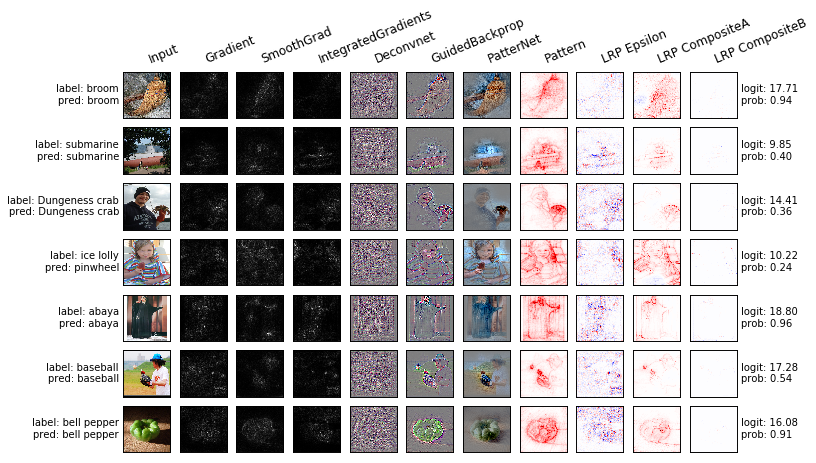

In [8]:
# Plot the analysis.

grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]  
row_labels = text
col_labels = [''.join(method[3]) for method in methods]

eutils.plot_image_grid(grid, 
                       row_labels, 
                       col_labels)